In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## The GE dataset

In [2]:
# DATA_FOLDER = "data/osbuddy/excess/"
DATA_FOLDER = "data/rsbuddy/"
buy_average = pd.read_csv(DATA_FOLDER + "buy_average.csv")
buy_average = buy_average.set_index('timestamp')

buy_average = buy_average.drop_duplicates()

item_to_predict = 'Rune_scimitar'
items_selected = ['Rune_axe', 'Rune_2h_sword', 'Rune_scimitar', 'Rune_chainbody', 'Rune_full_helm', 'Rune_kiteshield']
df = buy_average[items_selected].replace(to_replace=0, method='ffill')
print(df.shape)

(1086, 6)


# Feature Engineering

In [3]:
## Known finance features (MACD, RSI)

def moving_average_convergence(group, nslow=26, nfast=12):
    emaslow = group.ewm(span=nslow, min_periods=1).mean()
    emafast = group.ewm(span=nfast, min_periods=1).mean()
    result = pd.DataFrame({'MACD': emafast-emaslow, 'emaSlw': emaslow, 'emaFst': emafast})
    result = pd.DataFrame({'MACD': emafast-emaslow})
    return result

def moving_average(group, n=9):
    sma = group.rolling(n).mean()
    sma=sma.rename('SMA')
    return sma

def RSI(group, n=14):
    delta = group.diff()
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(n).mean()
    RolDown = dDown.rolling(n).mean().abs()
    
    RS = RolUp / RolDown
    rsi= 100.0 - (100.0 / (1.0 + RS))
    rsi=rsi.rename('RSI')
    return rsi

macd = moving_average_convergence(df[item_to_predict])
sma = moving_average(df[item_to_predict])
rsi = RSI(df[item_to_predict], 10)
finance_features = pd.concat([macd, rsi], axis=1)

## Fetched API features (buy quantity, sell price average)

sell_average = pd.read_csv(DATA_FOLDER + "sell_average.csv")
sell_average = sell_average.set_index('timestamp')
sell_average = sell_average.drop_duplicates()
sell_average = sell_average[items_selected].replace(to_replace=0, method='ffill')
sell_average.columns = [str(col) + '_sa' for col in sell_average.columns]

buy_quantity = pd.read_csv(DATA_FOLDER + "buy_quantity.csv")
buy_quantity = buy_quantity.set_index('timestamp')
buy_quantity = buy_quantity.drop_duplicates()
buy_quantity = buy_quantity[items_selected].replace(to_replace=0, method='ffill')
buy_quantity.columns = [str(col) + '_bq' for col in buy_quantity.columns]

sell_quantity = pd.read_csv(DATA_FOLDER + "sell_quantity.csv")
sell_quantity = sell_quantity.set_index('timestamp')
sell_quantity = sell_quantity.drop_duplicates()
sell_quantity = sell_quantity[items_selected].replace(to_replace=0, method='ffill')
sell_quantity.columns = [str(col) + '_sq' for col in sell_quantity.columns]

## Datetime properties

df['datetime'] = df.index
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
df['dayofweek'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

## Differentiated signal

tmp = df.copy()
tmp.index = pd.to_datetime(tmp.index)

slope = pd.Series(np.gradient(tmp[item_to_predict]), df.index, name='slope')
tmp = pd.concat([tmp, slope], axis=1)

## Appending features to main dataframe

df = pd.concat([df,finance_features, sell_average, buy_quantity, sell_quantity, slope], axis=1)
df = df.dropna()
print(df.shape)

(1076, 30)


# Time Series Analysis

## Part 1: Univariate time series

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

TRAIN_SPLIT = 750

tf.random.set_seed(13)

uni_data = df[item_to_predict]

uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std

univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

### Recurrent neural network

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 30ms/step - loss: 0.6622 - val_loss: 0.6215
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.6231 - val_loss: 0.5782
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5783 - val_loss: 0.5414
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5350 - val_loss: 0.5074
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5101 - val_loss: 0.4969
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.4975 - val_loss: 0.4965
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.4989 - val_loss: 0.4966
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.4950 - val_loss: 0.4969
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.4990 - val_loss: 0.4987
Epoch 10/10
200/200 [===========================

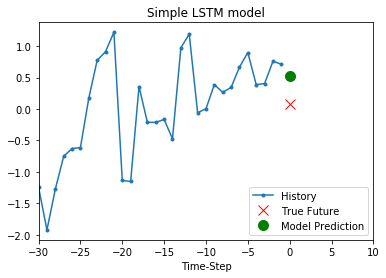

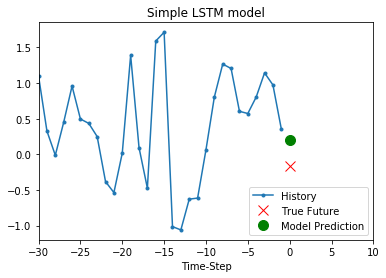

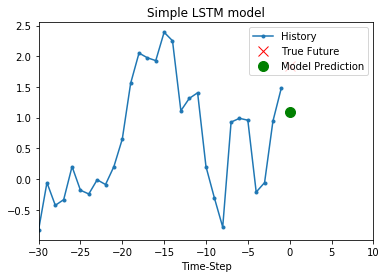

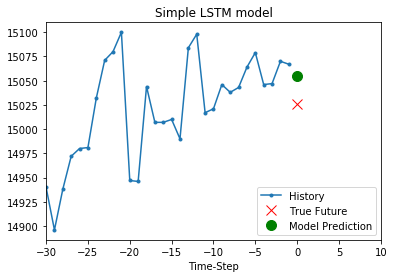

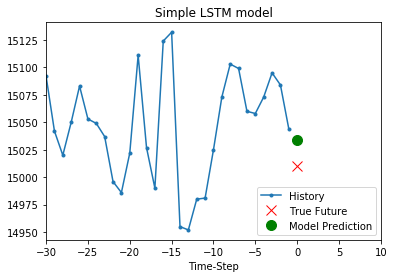

In [5]:
BATCH_SIZE = 32
BUFFER_SIZE = 30

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

#### Predict using the simple LSTM model


for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

#### Unnormalizing the data (so we can see actual prices in GP)

# unnormalized_data = (val_univariate*uni_train_std) + uni_train_mean
def unnormalized(val):
    return (val*uni_train_std) + uni_train_mean

for x, y in val_univariate.take(2):
    plot = show_plot([unnormalized(x[0].numpy()), unnormalized(y[0].numpy()),
                    unnormalized(simple_lstm_model.predict(x)[0])], 0, 'Simple LSTM model')
    plot.show()

## Part 2: Multivariate time series

In [6]:
features_considered = ['slope', item_to_predict, 'MACD', 'Rune_scimitar_bq']
# ['MACD', 'RSI', 'SMA', 'Rune_axe', 'Rune_axe_bq', 'Rune_axe_sq', 'Rune_axe_sa', 'hour', 'dayofweek', 'slope'
# 'Rune_2h_sword', 'Rune_scimitar', 'Rune_chainbody', 'Rune_full_helm', 'Rune_kiteshield']

features = df[features_considered]

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

### Single step model

In [11]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

past_history = 100
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.add(tf.keras.layers.Dropout(0.2))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.add(tf.keras.layers.Dropout(0.2))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae') #learning_rate=0.001

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future

for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model

In [21]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

future_target = 5
BATCH_SIZE = 5
BUFFER_SIZE = 100
past_history = 100
tf.random.set_seed(13)

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

def revert_data(val):
    return (val * data_std) + data_mean

def revert_target(val, index=1):
    return (val * data_std[index]) + data_mean[index]

def multi_step_plot(history, true_future, prediction, save_imgs=False, img_title="plot", index=0):
  fig = plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.title(img_title)
  if (save_imgs): fig.savefig('imgs/{}.png'.format(index))
  plt.show()
    

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target)) 
# multi_step_model.add(tf.keras.layers.Dropout(0.5))
# multi_step_model.add(tf.keras.layers.Dense(future_target))

# , kernel_regularizer=tf.keras.regularizers.l2(0.04)
# multi_step_model.add(tf.keras.layers.BatchNormalization())

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future

for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

#### Unnormalizing the data (so we can see actual prices in GP)

real val: 15150.0, predicted: 15059.796875, error: 90.203125
real val: 15150.0, predicted: 15050.091796875, error: 99.908203125
real val: 15047.0, predicted: 15043.841796875, error: 3.158203125
real val: 14858.0, predicted: 15034.4765625, error: 176.4765625
real val: 14853.0, predicted: 15027.21875, error: 174.21875
Average Error: 108.79296875
real profit: 22100.0, pred profit: 4678.125 -> pred buy: 1502721.875, real buy: 1485300.0, pred sell: 1507400.0, real sell: 1507400.0


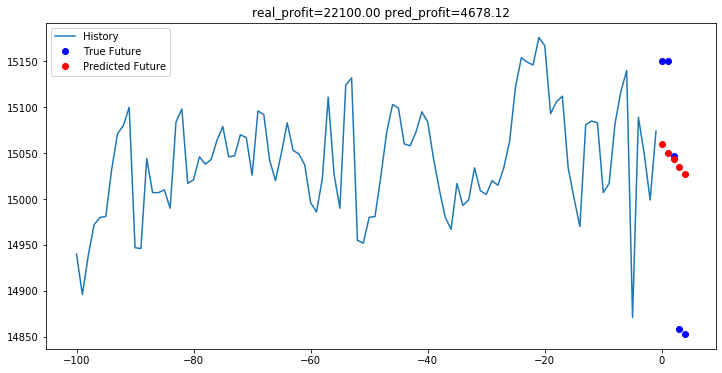

real val: 14902.0, predicted: 14992.35546875, error: 90.35546875
real val: 15013.0, predicted: 15027.8779296875, error: 14.8779296875
real val: 14968.0, predicted: 15063.9033203125, error: 95.9033203125
real val: 15034.0, predicted: 15051.1279296875, error: 17.1279296875
real val: 15095.0, predicted: 15071.412109375, error: 23.587890625
Average Error: 48.3705078125
real profit: 24200.0, pred profit: 21841.2109375 -> pred buy: 1485300.0, real buy: 1485300.0, pred sell: 1507141.2109375, real sell: 1509500.0


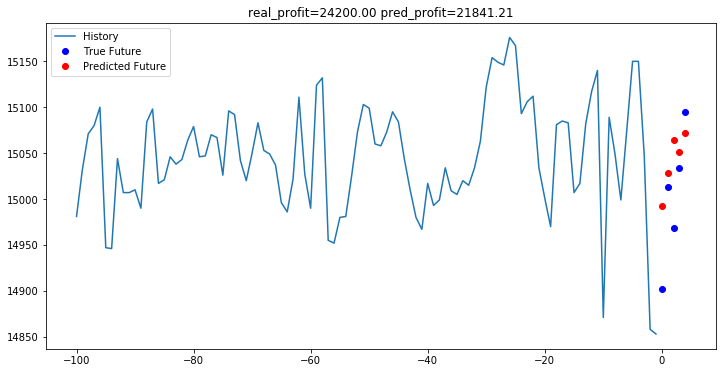

real val: 15040.0, predicted: 15068.1201171875, error: 28.1201171875
real val: 15000.0, predicted: 15073.837890625, error: 73.837890625
real val: 14962.0, predicted: 15071.0751953125, error: 109.0751953125
real val: 15026.0, predicted: 15065.9111328125, error: 39.9111328125
real val: 15005.0, predicted: 15054.3828125, error: 49.3828125
Average Error: 60.0654296875
real profit: 9000.0, pred profit: 4061.71875 -> pred buy: 1505438.28125, real buy: 1500500.0, pred sell: 1509500.0, real sell: 1509500.0


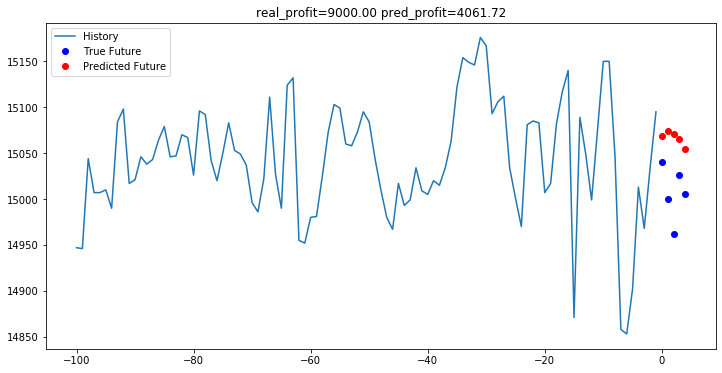

real val: 15001.0, predicted: 15053.443359375, error: 52.443359375
real val: 14973.0, predicted: 15055.0634765625, error: 82.0634765625
real val: 14979.0, predicted: 15049.75, error: 70.75
real val: 15102.0, predicted: 15046.65234375, error: 55.34765625
real val: 15080.0, predicted: 15041.0380859375, error: 38.9619140625
Average Error: 59.91328125
real profit: -3200.0, pred profit: 5006.34765625 -> pred buy: 1500500.0, real buy: 1500500.0, pred sell: 1505506.34765625, real sell: 1497300.0


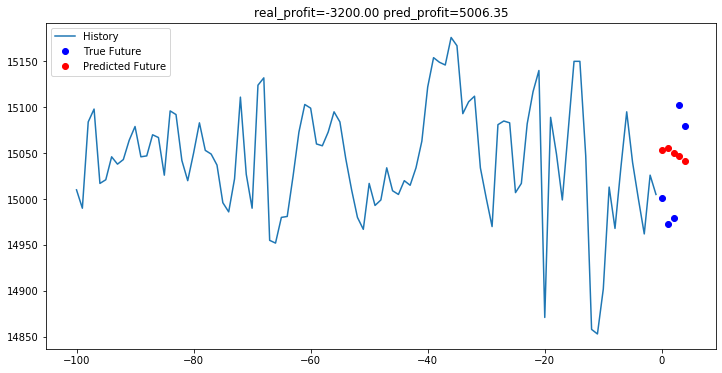

real val: 15036.0, predicted: 15040.7646484375, error: 4.7646484375
real val: 15061.0, predicted: 15046.373046875, error: 14.626953125
real val: 15047.0, predicted: 15038.267578125, error: 8.732421875
real val: 15059.0, predicted: 15032.791015625, error: 26.208984375
real val: 15065.0, predicted: 15039.0439453125, error: 25.9560546875
Average Error: 16.0578125
real profit: 2100.0, pred profit: 4720.8984375 -> pred buy: 1503279.1015625, real buy: 1505900.0, pred sell: 1508000.0, real sell: 1508000.0


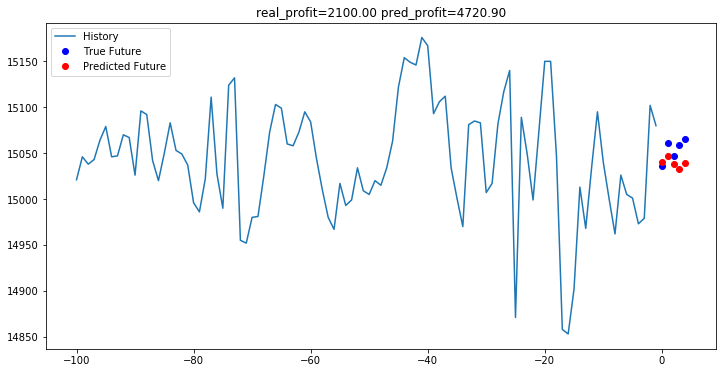

real val: 15047.0, predicted: 15031.2001953125, error: 15.7998046875
real val: 15055.0, predicted: 15037.62109375, error: 17.37890625
real val: 15014.0, predicted: 15033.40625, error: 19.40625
real val: 15037.0, predicted: 15030.4892578125, error: 6.5107421875
real val: 15148.0, predicted: 15044.59765625, error: 103.40234375
Average Error: 32.499609375
real profit: 2800.0, pred profit: 3451.07421875 -> pred buy: 1503048.92578125, real buy: 1503700.0, pred sell: 1506500.0, real sell: 1506500.0


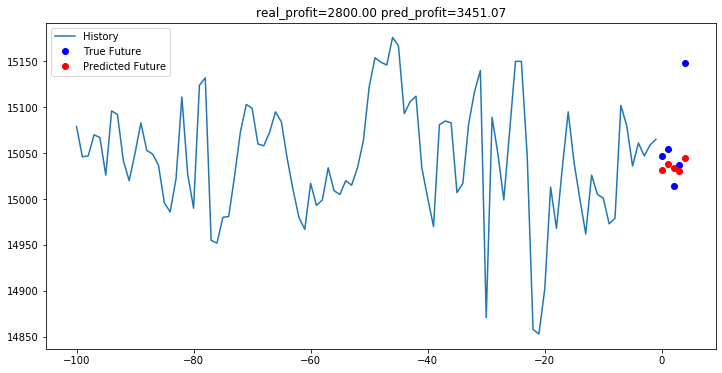

real val: 15117.0, predicted: 15041.87890625, error: 75.12109375
real val: 15021.0, predicted: 15055.9873046875, error: 34.9873046875
real val: 15013.0, predicted: 15063.6240234375, error: 50.6240234375
real val: 15014.0, predicted: 15063.4619140625, error: 49.4619140625
real val: 15021.0, predicted: 15084.1533203125, error: 63.1533203125
Average Error: 54.66953125
real profit: 3100.0, pred profit: 10612.109375 -> pred buy: 1504187.890625, real buy: 1511700.0, pred sell: 1514800.0, real sell: 1514800.0


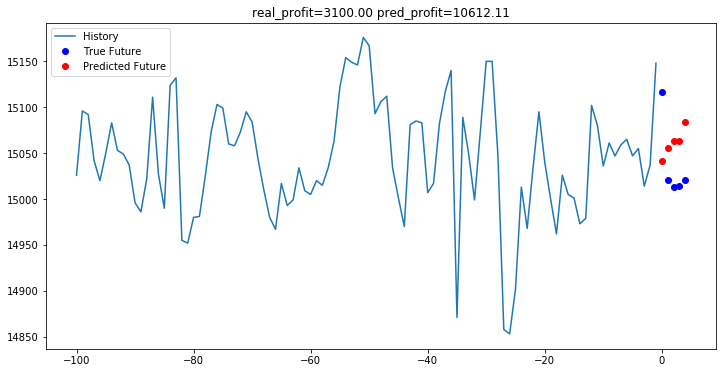

real val: 15009.0, predicted: 15084.38671875, error: 75.38671875
real val: 15010.0, predicted: 15103.072265625, error: 93.072265625
real val: 15040.0, predicted: 15104.8203125, error: 64.8203125
real val: 15033.0, predicted: 15095.107421875, error: 62.107421875
real val: 15021.0, predicted: 15105.5283203125, error: 84.5283203125
Average Error: 75.9830078125
real profit: 0.0, pred profit: 8452.83203125 -> pred buy: 1502100.0, real buy: 1502100.0, pred sell: 1510552.83203125, real sell: 1502100.0


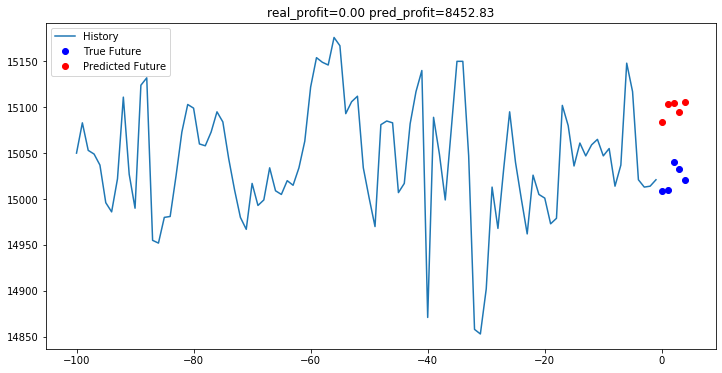

real val: 15026.0, predicted: 15072.1181640625, error: 46.1181640625
real val: 15020.0, predicted: 15078.646484375, error: 58.646484375
real val: 15013.0, predicted: 15073.8974609375, error: 60.8974609375
real val: 15050.0, predicted: 15058.76953125, error: 8.76953125
real val: 15045.0, predicted: 15061.12109375, error: 16.12109375
Average Error: 38.110546875
real profit: -100.0, pred profit: 5764.6484375 -> pred buy: 1502100.0, real buy: 1502100.0, pred sell: 1507864.6484375, real sell: 1502000.0


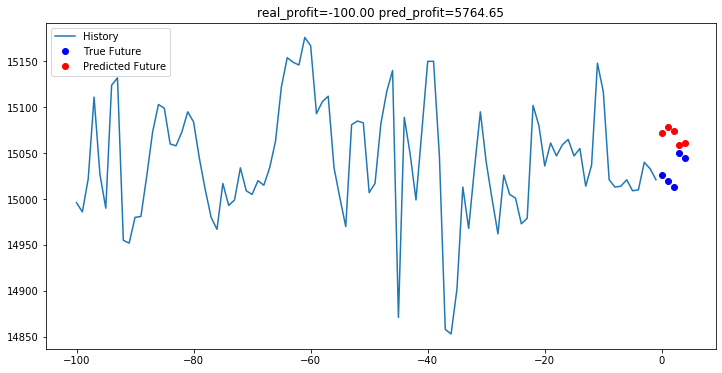

real val: 15046.0, predicted: 15040.8505859375, error: 5.1494140625
real val: 15044.0, predicted: 15036.099609375, error: 7.900390625
real val: 15016.0, predicted: 15028.83203125, error: 12.83203125
real val: 15014.0, predicted: 15022.9736328125, error: 8.9736328125
real val: 15009.0, predicted: 15020.4619140625, error: 11.4619140625
Average Error: 9.2634765625
real profit: 3600.0, pred profit: 2453.80859375 -> pred buy: 1502046.19140625, real buy: 1500900.0, pred sell: 1504500.0, real sell: 1504500.0


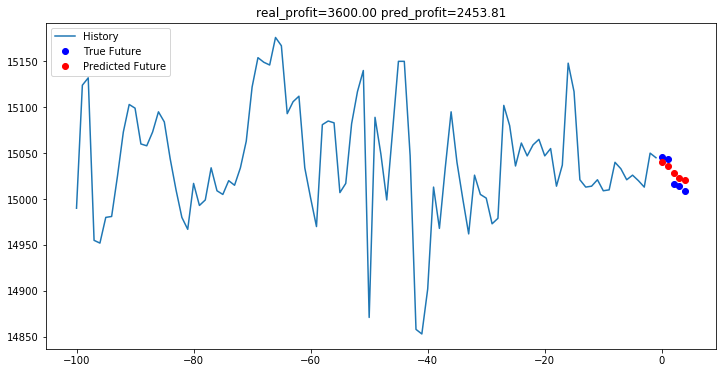

real val: 15007.0, predicted: 15009.8740234375, error: 2.8740234375
real val: 15045.0, predicted: 15015.0078125, error: 29.9921875
real val: 15076.0, predicted: 15026.0400390625, error: 49.9599609375
real val: 15096.0, predicted: 15027.552734375, error: 68.447265625
real val: 15099.0, predicted: 15034.1357421875, error: 64.8642578125
Average Error: 43.2275390625
real profit: 9000.0, pred profit: 2513.57421875 -> pred buy: 1500900.0, real buy: 1500900.0, pred sell: 1503413.57421875, real sell: 1509900.0


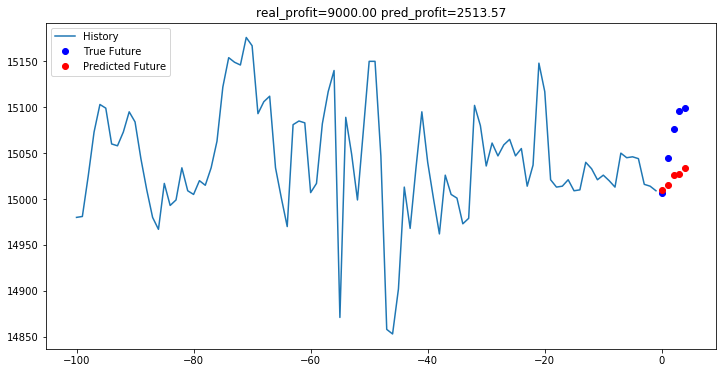

real val: 15101.0, predicted: 15039.8828125, error: 61.1171875
real val: 15005.0, predicted: 15032.560546875, error: 27.560546875
real val: 14998.0, predicted: 15043.9716796875, error: 45.9716796875
real val: 15003.0, predicted: 15058.5029296875, error: 55.5029296875
real val: 15042.0, predicted: 15052.72265625, error: 10.72265625
Average Error: 40.175
real profit: 9400.0, pred profit: 6643.9453125 -> pred buy: 1503256.0546875, real buy: 1500500.0, pred sell: 1509900.0, real sell: 1509900.0


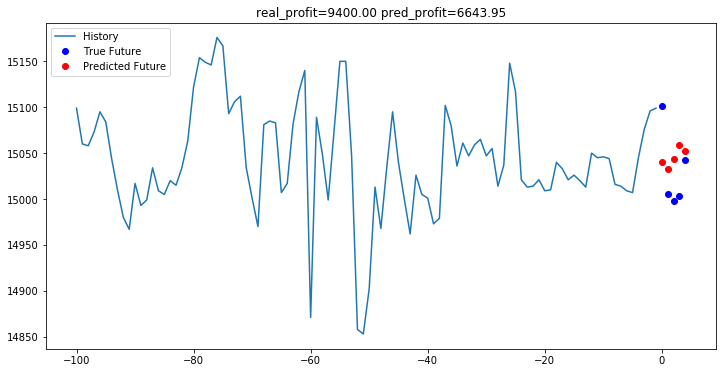

real val: 15036.0, predicted: 15055.6796875, error: 19.6796875
real val: 15011.0, predicted: 15065.890625, error: 54.890625
real val: 14983.0, predicted: 15074.7138671875, error: 91.7138671875
real val: 15022.0, predicted: 15076.0078125, error: 54.0078125
real val: 15057.0, predicted: 15067.265625, error: 10.265625
Average Error: 46.1115234375
real profit: -2000.0, pred profit: 3400.78125 -> pred buy: 1504200.0, real buy: 1504200.0, pred sell: 1507600.78125, real sell: 1502200.0


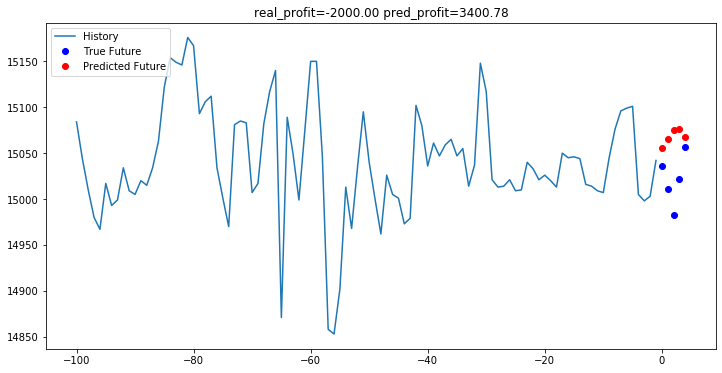

real val: 15031.0, predicted: 15028.947265625, error: 2.052734375
real val: 15005.0, predicted: 15018.0615234375, error: 13.0615234375
real val: 15017.0, predicted: 15014.2392578125, error: 2.7607421875
real val: 15082.0, predicted: 15006.4609375, error: 75.5390625
real val: 15080.0, predicted: 14992.3564453125, error: 87.6435546875
Average Error: 36.2115234375
real profit: -2300.0, pred profit: 6464.35546875 -> pred buy: 1499235.64453125, real buy: 1508000.0, pred sell: 1505700.0, real sell: 1505700.0


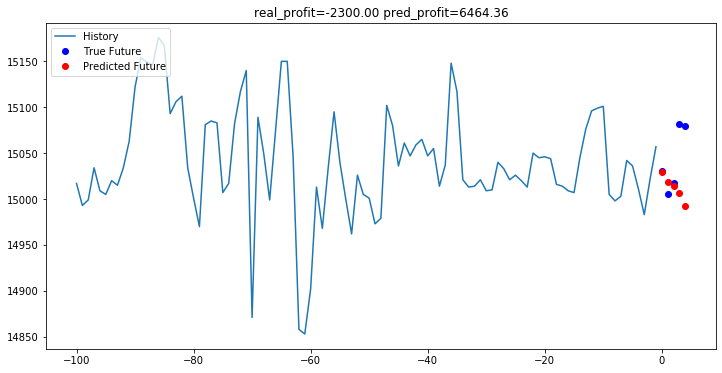

real val: 15000.0, predicted: 14991.052734375, error: 8.947265625
real val: 14993.0, predicted: 14987.2060546875, error: 5.7939453125
real val: 15080.0, predicted: 14986.1875, error: 93.8125
real val: 14936.0, predicted: 14987.4951171875, error: 51.4951171875
real val: 14932.0, predicted: 14985.306640625, error: 53.306640625
Average Error: 42.67109375
real profit: 14800.0, pred profit: 9469.3359375 -> pred buy: 1498530.6640625, real buy: 1493200.0, pred sell: 1508000.0, real sell: 1508000.0


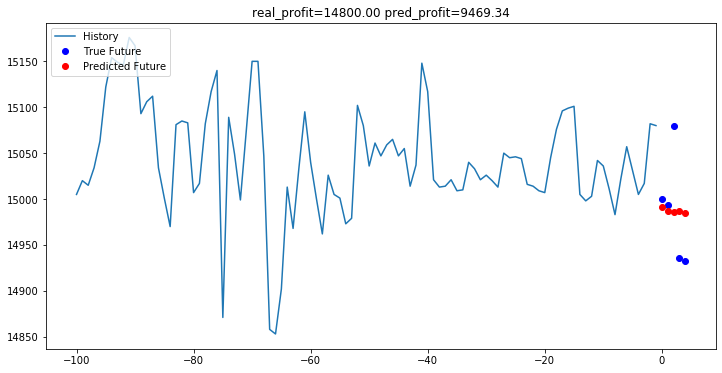

TOTAL PROFIT: 92500.0


In [32]:
SAVE_IMGS = False
current_image = 0
total_profit = 0
for x, y in val_data_multi.take(15):
    # plot out example inputs and predictions
    x_history = revert_data(x[0].numpy())
    true_future = revert_target(y[0].numpy())
    pred_future =  revert_target(multi_step_model.predict(x)[0])
    
    total_err = 0
    hi_index, hi_val = -1, x_history[-1,1]
    lo_index, lo_val = -1, x_history[-1,1]
    for idx, val in enumerate(true_future):
        # calculate absolute error for each point
        pred = pred_future[idx]
        err = abs(pred-val)
        total_err += err       
        print("real val: {}, predicted: {}, error: {}".format(val, pred, err))
        
        # For each prediction iteration, we sell at our highest point and buy at our lowest (including current point)     
        if (pred > hi_val):
            hi_index = idx
            hi_val = pred
        elif (pred < lo_val):
            lo_index = idx
            lo_val = pred
        
    print("Average Error: {}".format(total_err/future_target))
    
    # imagine we buy 100 of the given item
    num_items_flipped = 100
    predicted_buy, real_buy = num_items_flipped *lo_val, num_items_flipped *lo_val    
    predicted_sell, real_sell = num_items_flipped *hi_val, num_items_flipped *hi_val
    if (lo_index >= 0):
        predicted_buy = num_items_flipped * lo_val
        real_buy = num_items_flipped * true_future[lo_index]
    if (hi_index >= 0):
        predicted_sell = num_items_flipped * hi_val
        real_sell = num_items_flipped * true_future[hi_index]
    print('real profit: {}, pred profit: {} -> pred buy: {}, real buy: {}, pred sell: {}, real sell: {}'\
          .format(real_sell - real_buy, predicted_sell - predicted_buy, predicted_buy, real_buy, predicted_sell, real_sell))
    
    multi_step_plot(x_history, true_future, pred_future, save_imgs=SAVE_IMGS, img_title="real_profit={:0.2f} pred_profit={:0.2f}"\
                    .format(real_sell - real_buy, predicted_sell - predicted_buy), index=current_image)
    current_image += 1
    total_profit += (real_sell - real_buy)
    
print("TOTAL PROFIT: {}".format(total_profit))


## Feature Selection

In [33]:
# Univariate linear regression tests and Recursive Feature Elimination (RFE)
from sklearn import datasets
from sklearn.feature_selection import RFE, f_regression, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Regression F Test

In [34]:
features = df.drop(['datetime'], axis=1).copy()

# normalize dataset
dataset=(features-features.mean())/features.std()
    
X = dataset.drop([item_to_predict], axis=1)
y = dataset[item_to_predict]
print(X.shape)
print(y.shape)

# define feature selection
fs = SelectKBest(score_func=f_regression, k=7)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

# Get scores for each of the columns
scores = fs.scores_
for idx, col in enumerate(X.columns): 
    print("feature: {: >20} \t score: {: >10}".format(col, round(scores[idx],5)))

# Get columns to keep and create new dataframe with those only
cols = fs.get_support(indices=True)
features_df_new = X.iloc[:,cols]
print(features_df_new.columns)
features_df_new.head()


(1076, 28)
(1076,)
(1076, 7)
feature:             Rune_axe 	 score:    0.19375
feature:        Rune_2h_sword 	 score:    3.87857
feature:       Rune_chainbody 	 score:     3.5647
feature:       Rune_full_helm 	 score:    22.9884
feature:      Rune_kiteshield 	 score:    2.19837
feature:            dayofweek 	 score:    1.55558
feature:                 hour 	 score:   10.97583
feature:                 MACD 	 score:  827.07558
feature:                  RSI 	 score:    489.208
feature:          Rune_axe_sa 	 score:    2.27552
feature:     Rune_2h_sword_sa 	 score:    4.43778
feature:     Rune_scimitar_sa 	 score:   93.11519
feature:    Rune_chainbody_sa 	 score:   18.11522
feature:    Rune_full_helm_sa 	 score:   31.46169
feature:   Rune_kiteshield_sa 	 score:   11.90286
feature:          Rune_axe_bq 	 score:     9.8511
feature:     Rune_2h_sword_bq 	 score:    4.32544
feature:     Rune_scimitar_bq 	 score:  138.17608
feature:    Rune_chainbody_bq 	 score:    0.23186
feature:    Rune_full

,Rune_full_helm,MACD,RSI,Rune_scimitar_sa,Rune_full_helm_sa,Rune_scimitar_bq,Rune_scimitar_sq
timestamp,,,,,,,
1577246100,0.723001,-0.253769,-1.004653,0.259116,0.184059,1.351232,-0.539474
1577247901,0.723001,-0.035878,0.262390,0.590342,0.160513,-0.574403,-0.567118
1577249700,2.169899,0.117567,0.598359,0.590342,0.113420,-0.659986,-0.521045
1577251500,2.169899,-0.176225,-0.874509,0.557220,0.372429,-0.189276,-0.640835
1577253301,-0.763003,-0.273201,-0.349149,0.292239,-0.098496,1.137272,-0.732981


### Recursive Feature Elimination (RFE)

In [35]:
X = dataset.drop([item_to_predict], axis=1)
y = dataset[item_to_predict]

# perform feature selection
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), 7)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = dataset.drop([item_to_predict], axis=1).columns.values
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])

Selected Features:
MACD
RSI
Rune_scimitar_sa
Rune_full_helm_sa
Rune_scimitar_bq
Rune_scimitar_sq
slope


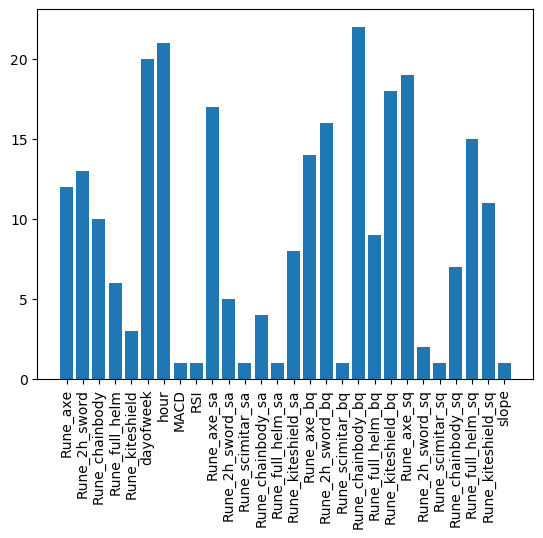

In [36]:
mpl.rcParams.update(mpl.rcParamsDefault)
# plot feature rank
names = dataset.drop([item_to_predict], axis=1).columns.values
ticks = [i for i in range(len(names))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names)
plt.xticks(rotation=90);
plt.show()